In [199]:
import logging
from collections import namedtuple
import random
from typing import Callable
from copy import deepcopy
from itertools import accumulate
from operator import xor
from matplotlib import pyplot as plt
import numpy as np
import math
import json
import os
from copy import deepcopy, copy
from collections import Counter


logging.basicConfig(
    format="[%(asctime)s] %(levelname)s: %(message)s",
    datefmt="%H:%M:%S",
    level=logging.INFO,
)

In [200]:
Nimply = namedtuple("Nimply", "row, num_objects")

In [201]:
class Nim:
    def __init__(self, num_rows: int, k: int = None, state = None) -> None:
        if state:
            self._rows = state
        else:
            self._rows = [i * 2 + 1 for i in range(num_rows)]
            self._k = k
            self._sticks = sum(self._rows)

    def __bool__(self):
        return sum(self._rows) > 0

    def __str__(self):
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    def __eq__(self, __o: object) -> bool:
        # return self._sticks == __o._sticks
        return Counter(self._rows) == Counter(__o._rows)
        
    def __hash__(self) -> int:
        return hash(Counter(self._rows).__str__())
        
    @property
    def rows(self) -> tuple:
        return tuple(self._rows)

    @property
    def k(self) -> int:
        return self._k

    @property
    def sticks(self) -> int:
        return self._sticks

    def nimming(self, ply: Nimply) -> None:
        row, num_objects = ply
        assert self._rows[row] >= num_objects
        assert self._k is None or num_objects <= self._k
        self._rows[row] -= num_objects

    # -1 if I don't win, 0 if I make the last winnning move
    def give_reward(self) -> int:
        return -1 * int(self.__bool__())

    def get_state_and_reward(self):
        return self, self.give_reward()
         

In [202]:
def nim_sum(state: Nim) -> int:
    *_, result = accumulate(state.rows, xor)
    return result


def cook_status(state: Nim, complete=False) -> dict:
    cooked = dict()
    cooked["possible_moves"] = [
        (r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1) if state.k is None or o <= state.k
    ]
    cooked["active_rows_number"] = sum(o > 0 for o in state.rows)
    cooked["shortest_row"] = min((x for x in enumerate(state.rows) if x[1] > 0), key=lambda y: y[1])[0]
    cooked["longest_row"] = max((x for x in enumerate(state.rows)), key=lambda y: y[1])[0]
    cooked["completation"] = sum(state.rows)/state.sticks
    if complete:
        brute_force = list()
        cooked["nim_sum"] = nim_sum(state)
        for m in cooked["possible_moves"]:
            tmp = deepcopy(state)
            tmp.nimming(m)
            brute_force.append((m, nim_sum(tmp)))
        cooked["brute_force"] = brute_force
    return cooked

In [203]:
def optimal_strategy(state: Nim) -> Nimply:
    data = cook_status(state, complete = True)
    return next((bf for bf in data["brute_force"] if bf[1] == 0), random.choice(data["brute_force"]))[0]


In [204]:
def aggressive(state: Nim) -> Nimply:
    """Pick always the entire row if the number of active rows is odd"""
    data = cook_status(state)
    if data['active_rows_number'] % 2 == 0:
        # random move
        row, num_objects = random.choice(data['possible_moves'])
    else:
        # aggressive move
        row = data['longest_row']
        num_objects = state.rows[row]
    return Nimply(row, num_objects)

In [205]:
strategy = (aggressive, optimal_strategy)

nim = Nim(4)
logging.debug(f"status: Initial board  -> {nim}")
player = 0
while nim:
    ply = strategy[player](nim)
    logging.debug(f"{player}: {ply}")
    nim.nimming(ply)
    logging.debug(f"status: After player {player} -> {nim}")
    player = 1 - player
winner = 1 - player
logging.info(f"status: Player {winner} won!")

[12:29:57] INFO: status: Player 1 won!


In [206]:
class Agent():
    def __init__(self, nim, alpha = 0.1, random_factor = 0.2) -> None:
        self.state_history = []
        self.alpha = alpha
        self.random_factor = random_factor
        self.G = {}
        self.init_reward(nim)

    def init_reward(self, nim) -> dict:
        result = []
        def generate_states(rows, current_state):
            if len(current_state) == len(rows):
                # We have generated a valid state 
                result.append(current_state)
                return
            # Generate all possible states for the current row
            for i in range(rows[len(current_state)] + 1):
                new_state = current_state + [i]
                generate_states(rows, new_state)
        
        generate_states(nim.rows, [])
        for state in result:
            self.G[Nim(NIM_SIZE, state=state)] = np.random.uniform(low=1.0, high=0.1)     

    def choose_action(self, state) -> Nimply:
        maxG = -10e15
        next_move = None
        possible_moves = [(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)]
        if np.random.random() < self.random_factor:
            next_move = random.choice(possible_moves) 
        else:
            for action in possible_moves:
                # print(f"Action: {action}")
                new_state = deepcopy(state)
                new_state.nimming(action)
                # print(f"Check {new_state}")
                if self.G[new_state] >= maxG:
                    next_move = action
                    maxG = self.G[new_state]
        return next_move

    def update_state_history(self, state, reward):
        self.state_history.append((state, reward))

    def learn(self):
        target = 0

        for prev, reward in reversed(self.state_history):
            self.G[prev] = self.G[prev] + self.alpha * (target - self.G[prev])
            target += reward

        self.state_history = []

        self.random_factor -= 10e-5  # decrease random factor each episode of play

    def get_strategy(self) -> Callable:
        def agent_strategy(state: Nim) -> Nimply:
            action = self.choose_action(state)
            # print(f"Choosen action: {action}")
            return Nimply(action[0], action[1])
        return agent_strategy

### Reinforcement learning strategies


In [207]:
# Costants
NUM_EPOCHS = 5000
NIM_SIZE = 4
OPPONENTS = [aggressive, optimal_strategy]

# Create the agent
game = Nim(NIM_SIZE)
agent = Agent(game, alpha=0.15, random_factor=0)

states = agent.G


In [208]:
# for state in states:
#     print(f"{state}: {states[state]}")
win_logs = []
for i in range(NUM_EPOCHS):
    # logging.debug(f"Starting the game #{i}")
    current_game = Nim(NIM_SIZE)
    turn = True
    OPPONENT = OPPONENTS[0]
    while current_game:
        if turn:
            # my agent turn
            state, _ = current_game.get_state_and_reward() # forse è inutile
            action = agent.choose_action(current_game)
            # print(f"Action: {action}")
            current_game.nimming(action)
            state, reward = current_game.get_state_and_reward()
            # print(f"{state} -> {reward}")
            agent.update_state_history(state, reward)
        else:
            action = OPPONENT(current_game)
            current_game.nimming(action)
        turn = not turn
    winner = int(not turn)
    win_logs.append(winner)
    # logging.debug(f"The game ended. Player {winner} wins")
    agent.learn()


agent_strategy = agent.get_strategy()


In [209]:
NUM_MATCHES = 100

def evaluate_against(strategy: Callable, against: Callable) -> float:
    opponent = (strategy, against)
    won = 0
    for _ in range(NUM_MATCHES):
        nim = Nim(NIM_SIZE)
        player = 0
        while nim:
            # logging.debug(nim)
            ply = opponent[player](nim)
            nim.nimming(ply)
            player = 1 - player
        if player == 1: # winner is the zero
            won += 1
        # logging.debug(f"player {1 - player} has won.")
    return won / NUM_MATCHES

In [210]:
for state in states:
    print(f"{state}: {states[state]}")

<0 0 0 0>: -1.1375615241911703
<0 0 0 1>: 0.8316498871187342
<0 0 0 2>: 0.32674792370799344
<0 0 0 3>: 0.3488411856059014
<0 0 0 4>: 0.41730728886086554
<0 0 0 5>: 0.996530615104529
<0 0 0 6>: 0.7472978508325069
<0 0 0 7>: 0.33223482120256154
<0 0 1 1>: 0.21679568088688927
<0 0 1 2>: 0.38607192171165483
<0 0 1 3>: 0.4925820137268295
<0 0 1 4>: 0.1845417421172787
<0 0 1 5>: 0.213707412521846
<0 0 1 6>: 0.18576687536956304
<0 0 1 7>: 0.12517333212992654
<0 0 2 1>: 0.15897042212278234
<0 0 2 2>: 0.2481801860744115
<0 0 2 3>: 0.6115856545532743
<0 0 2 4>: 0.4744514966645519
<0 0 2 5>: 0.655714052751956
<0 0 2 6>: 0.36665533158154906
<0 0 2 7>: 0.765937382956876
<0 0 3 1>: 0.8327548116255462
<0 0 3 2>: 0.966474311444316
<0 0 3 3>: 0.855305455221647
<0 0 3 4>: 0.6596103123965864
<0 0 3 5>: 0.5628642750047264
<0 0 3 6>: 0.5243996432999003
<0 0 3 7>: 0.2760257006095993
<0 0 4 1>: 0.3008899940059674
<0 0 4 2>: 0.786408418202004
<0 0 4 3>: 0.48215736912004825
<0 0 4 4>: 0.6589364208536128
<0 0 4

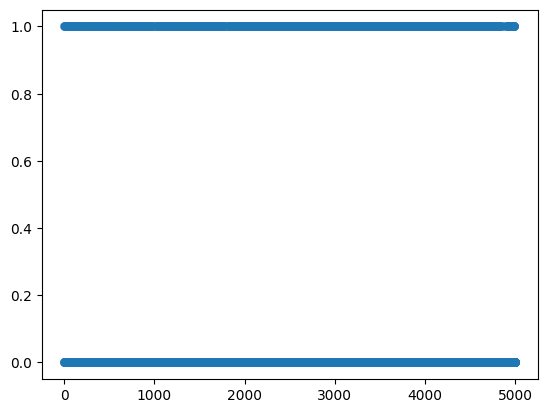

In [211]:
plt.scatter(range(NUM_EPOCHS), win_logs, marker='o', linewidths=.2, edgecolors=None)
plt.show()

In [212]:
evaluate_against(agent_strategy, optimal_strategy)

0.0